# 🔍 Seeds Veri Seti Üzerinde KNN Sınıflandırması
Bu çalışmada, Seeds veri seti üzerinde veri ön işleme, özellik seçimi ve sınıflandırma işlemleri yapılacaktır. Ayrıca başarı değerlendirme metrikleri de sunulacaktır.

## 📄 Veri Seti Açıklaması
- **Özellikler:**
  1. area
  2. perimeter
  3. compactness
  4. length of kernel
  5. width of kernel
  6. asymmetry coefficient
  7. length of kernel groove

- **Sınıf bilgisi (target):**
  - 3 farklı buğday türü.
- **Toplam Örnek Sayısı:** 210


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint as sp_randint

# Veri yükle
df = pd.read_csv("Seed_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       210 non-null    float64
 1   P       210 non-null    float64
 2   C       210 non-null    float64
 3   LK      210 non-null    float64
 4   WK      210 non-null    float64
 5   A_Coef  210 non-null    float64
 6   LKG     210 non-null    float64
 7   target  210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


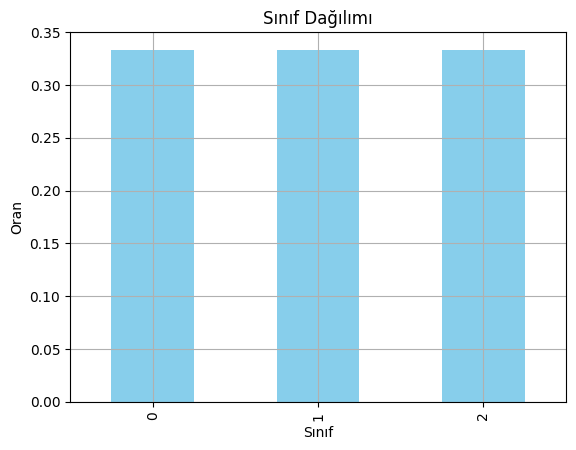

In [2]:
# Sınıf dağılımı grafiği
df['target'].value_counts(normalize=True).plot.bar(color='skyblue')
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Oran')
plt.grid(True)
plt.show()

## ⚙️ Veri Ön İşleme
- Veriler `StandardScaler` ile ölçeklendirilmiştir (ortalama=0, std=1).
- Bu, KNN gibi mesafe tabanlı algoritmalar için önemlidir.

In [14]:
X = df.drop("target", axis=1)
y = df["target"]

# Standardizasyon
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## ✅ Özellik Seçimi (SelectKBest + ANOVA F-test)
- `SelectKBest`, en iyi 5 özelliği seçmek için `f_classif` (ANOVA F-test) istatistiğini kullanır.
- Bu işlem, sınıf bilgisiyle en çok ilişkili özellikleri korur.

Seçilen özellik indeksleri: [0 1 3 4 6]
Seçilen özellik isimleri: ['A', 'P', 'LK', 'WK', 'LKG']


C:\Users\EdaNurIsik\AppData\Local\Temp\ipykernel_1568\2652581380.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Skoru', y='Özellik', data=feature_scores_df, palette='viridis')


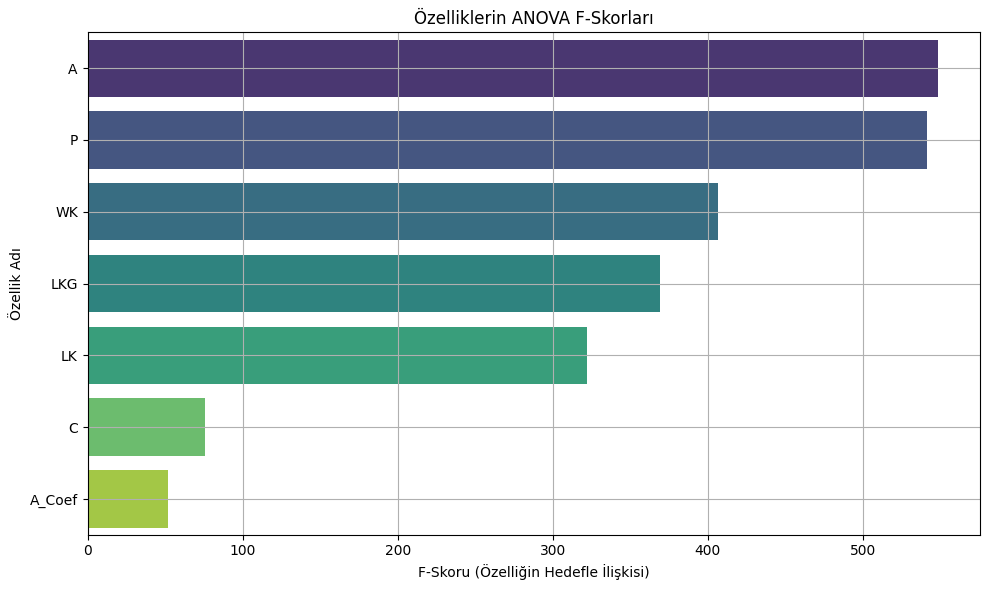

In [17]:
# 2️⃣ Özellik Seçimi (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features].tolist()

# Seçilen özellikler
print("Seçilen özellik indeksleri:", selected_features)
print("Seçilen özellik isimleri:", selected_feature_names)

# 3️⃣ Görselleştirme: Özelliklerin F-skorları
f_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Özellik': X.columns, 'F-Skoru': f_scores})

# Skorları büyükten küçüğe sırala
feature_scores_df = feature_scores_df.sort_values(by='F-Skoru', ascending=False)

# Grafik
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Skoru', y='Özellik', data=feature_scores_df, palette='viridis')
plt.title("Özelliklerin ANOVA F-Skorları")
plt.xlabel("F-Skoru (Özelliğin Hedefle İlişkisi)")
plt.ylabel("Özellik Adı")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🤖 KNN Sınıflandırması ve Başarı Değerlendirme

1️⃣ Eğitim = Test doğruluk: 0.9429


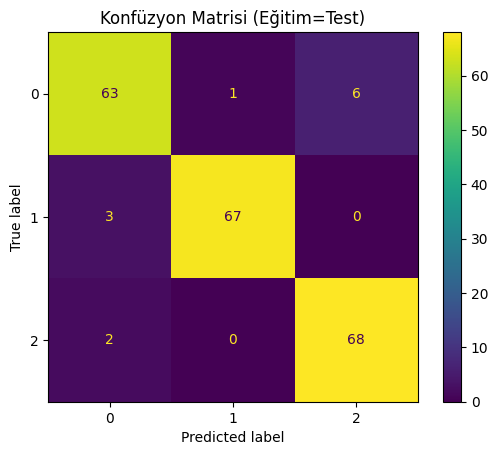

In [10]:
params = {'n_neighbors': sp_randint(1, 20), 'p': sp_randint(1, 5)}
knn = KNeighborsClassifier()
rsearch_knn = RandomizedSearchCV(knn, param_distributions=params, cv=3, n_iter=50,
                                 random_state=3, n_jobs=-1)
rsearch_knn.fit(X_selected, y)
best_knn = KNeighborsClassifier(**rsearch_knn.best_params_)

# Eğitim = test
best_knn.fit(X_selected, y)
y_pred_train = best_knn.predict(X_selected)
acc_train = accuracy_score(y, y_pred_train)
cm_train = confusion_matrix(y, y_pred_train)
print(f"1️⃣ Eğitim = Test doğruluk: {acc_train:.4f}")
ConfusionMatrixDisplay(cm_train).plot()
plt.title("Konfüzyon Matrisi (Eğitim=Test)")
plt.show()

2️⃣ %70-30 Test doğruluk: 0.8889


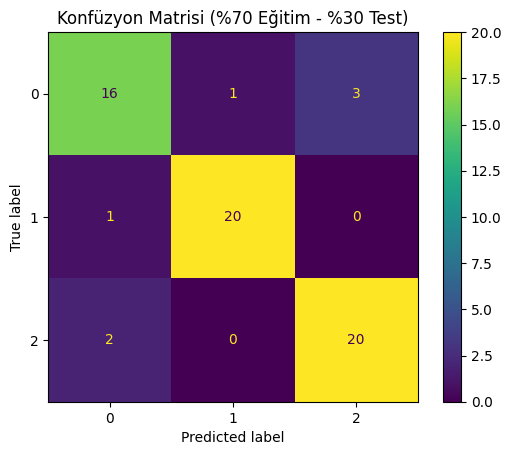

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
best_knn.fit(X_train, y_train)
y_pred_test = best_knn.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print(f"2️⃣ %70-30 Test doğruluk: {acc_test:.4f}")
ConfusionMatrixDisplay(cm_test).plot()
plt.title("Konfüzyon Matrisi (%70 Eğitim - %30 Test)")
plt.show()

3️⃣ 5 Katlı Çapraz Doğrulama doğruluk: 0.9190


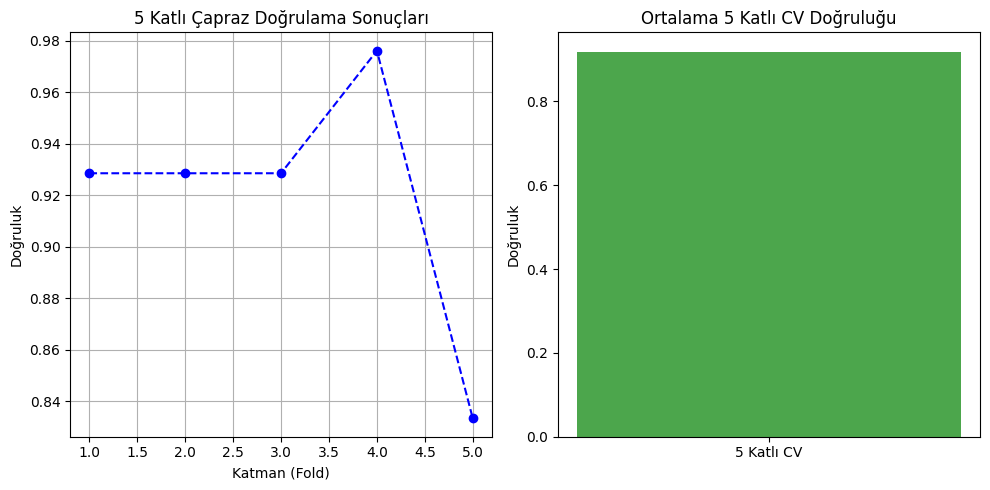

In [7]:
cv_scores = cross_val_score(best_knn, X_selected, y, cv=5)
acc_cv = cv_scores.mean()
print(f"3️⃣ 5 Katlı Çapraz Doğrulama doğruluk: {acc_cv:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), cv_scores, marker='o', color='b', linestyle='--')
plt.xlabel('Katman (Fold)')
plt.ylabel('Doğruluk')
plt.title('5 Katlı Çapraz Doğrulama Sonuçları')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(['5 Katlı CV'], [acc_cv], color='green', alpha=0.7)
plt.ylabel('Doğruluk')
plt.title('Ortalama 5 Katlı CV Doğruluğu')

plt.tight_layout()
plt.show()